# Lagrange Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# load dataset
data_raw = pd.read_csv('LagrangeJournalBirdStrikeValueupto50.csv')

In [3]:
data_raw.describe()

,test_set,Bird(m/s),Blade(rad/s),Max_TD(mm),Von_Mises_Stress(pascal),Total_Energy
count,49.00000,49.000000,49.000000,49.000000,4.900000e+01,4.900000e+01
mean,25.00000,182.500000,515.000000,0.670000,1.167274e+09,1.821396e+06
std,14.28869,35.721725,71.443451,0.188392,4.449917e+07,5.044295e+05
min,1.00000,122.500000,395.000000,0.350000,1.059400e+09,1.037200e+06
25%,13.00000,152.500000,455.000000,0.490000,1.151850e+09,1.390000e+06
50%,25.00000,182.500000,515.000000,0.740000,1.172436e+09,1.787100e+06
75%,37.00000,212.500000,575.000000,0.830000,1.195846e+09,2.234322e+06
max,49.00000,242.500000,635.000000,0.950000,1.276456e+09,2.731651e+06


# Plot outputs

MAX_TD(mm)

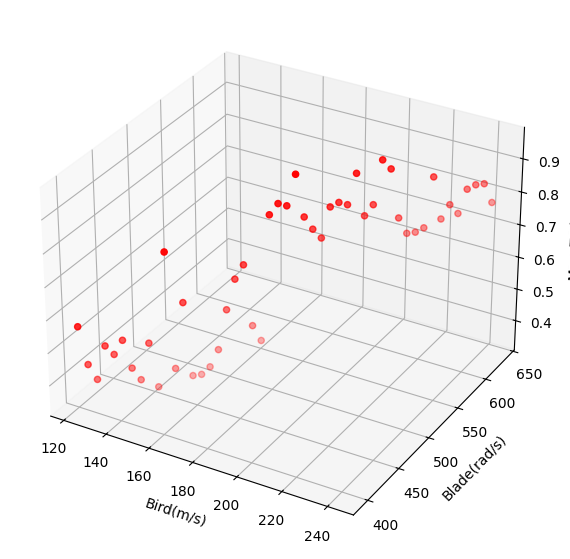

In [4]:
# plot MAX_TD vs Bird and Blade
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Max_TD(mm)'], c='r', marker='o')
ax.set_xlabel('Bird(m/s)')
ax.set_ylabel('Blade(rad/s)')
ax.set_zlabel('Max_TD(mm)')
plt.show()

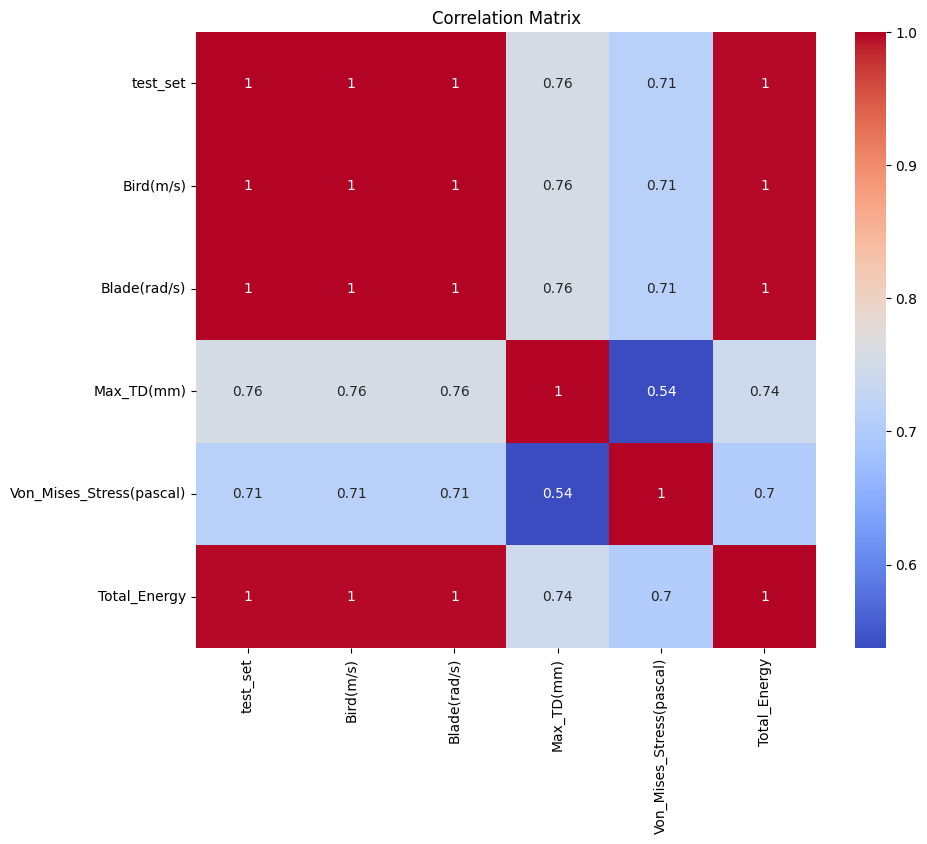

In [5]:
# Plot the correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = data_raw.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 1. Random Forest Regressor (RF)

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = data_raw[['Bird(m/s)', 'Blade(rad/s)']]
y = data_raw['Max_TD(mm)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=25,
    random_state=42,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

print ("\n k mean cross validation \n")

# Do K mean cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
    n_estimators=25,
    random_state=42,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1
    )
    
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf = rf_model_kf.predict(X_test_kf)
    
    mse_kf = mean_squared_error(y_test_kf, y_pred_kf)
    rmse_kf = np.sqrt(mse_kf)
    rmse_list.append(rmse_kf)
average_rmse = np.mean(rmse_list)
print(f"Average RMSE from K-Fold CV: {average_rmse:.4f}")
print(f"RMSEs from each fold: {rmse_list}")
print(f"R²   : {r2:.4f}")
print(f"MSE  : {mse:.4f}")

# At fold 4 :
# likely at very high or very low speeds the model finds harder to predict.

RMSE : 0.0749
R²   : 0.7703

 k mean cross validation 

Average RMSE from K-Fold CV: 0.0953
RMSEs from each fold: [np.float64(0.08913012650879572), np.float64(0.07330458067251801), np.float64(0.07807633358195623), np.float64(0.1374471583838876), np.float64(0.09831298412849102)]
R²   : 0.7703
MSE  : 0.0056


Starting Grid Search...
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

--- Final Model Results (on Hold-out Test Set) ---
RMSE : 0.0829
R²   : 0.7186

--- 5-Fold Cross Validation (Stability Check) ---
Average RMSE: 0.0935
RMSE per Fold: [0.08512273 0.06952292 0.06737501 0.13647957 0.10894418]
RMSE Standard Deviation: 0.0261


C:\Users\MTBD\AppData\Local\Temp\ipykernel_10668\3433293388.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


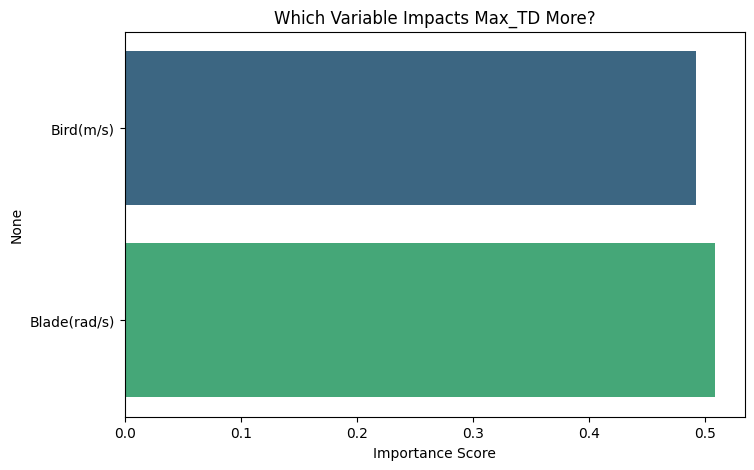

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare Data
# Keeping only the independent physical variables
X = data_raw[['Bird(m/s)', 'Blade(rad/s)']]
y = data_raw['Max_TD(mm)']

# Initial Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Setup Grid Search to find optimal Hyperparameters
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

print("Starting Grid Search...")
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

# 3. Final Model Evaluation
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Final Model Results (on Hold-out Test Set) ---")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# 4. Rigorous K-Fold Cross-Validation
print("\n--- 5-Fold Cross Validation (Stability Check) ---")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Average RMSE: {cv_rmse.mean():.4f}")
print(f"RMSE per Fold: {cv_rmse}")
print(f"RMSE Standard Deviation: {cv_rmse.std():.4f}")

# 5. Research Insight: Feature Importance
importances = best_rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title('Which Variable Impacts Max_TD More?')
plt.xlabel('Importance Score')
plt.show()

# 2. Gaussian Process Regression (GPR)

In [9]:
# Gaussian Process Regression (GPR) model to predict Max_TD
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gpr_model.fit(X_train_scaled, y_train)
y_pred_gpr = gpr_model.predict(X_test_scaled)
mse_gpr = mean_squared_error(y_test, y_pred_gpr)
r2_gpr = r2_score(y_test, y_pred_gpr)
print(f'GPR Model - MSE: {mse_gpr:.4f}')
print(f'GPR Model - RMSE: {np.sqrt(mse_gpr):.4f}')
print(f'GPR R² Score: {r2_gpr:.4f}')

GPR Model - MSE: 0.0088
GPR Model - RMSE: 0.0941
GPR R² Score: 0.6377


# 3. Support Vector Regression (SVR) with RBF Kernel

In [10]:
# Prepare features and target
X = data_raw[['Bird(m/s)', 'Blade(rad/s)']]
y = data_raw['Max_TD(mm)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR model
model = SVR(kernel='rbf', C=160, gamma= 1, epsilon=0.1)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

# model = SVR(kernel='rbf', C=160, gamma= 0.2, epsilon=0.1)
# Mean Squared Error: 0.0053
# RMSE: 0.0729
# R² Score: 0.7825

Mean Squared Error: 0.0062
RMSE: 0.0790
R² Score: 0.7447


In [11]:
# Example prediction
example_data = np.array([[132, 400]])  # Example: Bird speed = 132 m/s, Blade speed = 400 rad/s
example_data_scaled = scaler.transform(example_data)
predicted_max_td = model.predict(example_data_scaled)
print(f'Predicted Max_TD(mm) for Bird=132 m/s and Blade=400 rad/s: {predicted_max_td[0]:.4f} mm')

Predicted Max_TD(mm) for Bird=132 m/s and Blade=400 rad/s: 0.4810 mm


C:\Users\MTBD\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 4. Polynomial Regression

In [12]:
# polynomial regression model to predict Max_TD
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)
lin_reg.fit(X_train_poly, y_train)
y_pred_poly = lin_reg.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f'Polynomial Regression Model - MSE: {mse_poly:.4f}')
print(f'Polynomial Regression Model - RMSE: {np.sqrt(mse_poly):.4f}')
print(f'Polynomial Regression R² Score: {r2_poly:.4f}')

Polynomial Regression Model - MSE: 0.0067
Polynomial Regression Model - RMSE: 0.0819
Polynomial Regression R² Score: 0.7254
